# IEEE 9-Bus Load Flow Project

This notebook is structured in two main parts requested in the assignment:

1. **Task-1 (Activity 1):** Full Newton-Raphson load-flow program development from first principles.
2. **Task-3 (Activity 2):** Voltage sensitivity analysis under independent load variation.

All calculations use the provided `IEEE9_Bus_system_data.json` file and per-unit modeling on a 100 MVA base.


## Task-1: Full Newton-Raphson Program Development (Activity 1)

### 1.1 Mathematical Model

The power-flow state vector is:

\[
\mathbf{x} = \begin{bmatrix}
\delta_2,\ldots,\delta_n,\; |V|_{PQ}
\end{bmatrix}^{\mathsf{T}}
\]

with mismatch equations:

\[
\Delta P_i = P_i^{spec} - P_i^{calc}, \qquad
\Delta Q_i = Q_i^{spec} - Q_i^{calc}
\]

and Newton update:

\[
\mathbf{J}(\mathbf{x}^{(k)})\,\Delta \mathbf{x}^{(k)} = \Delta \mathbf{f}^{(k)}, \qquad
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \Delta \mathbf{x}^{(k)}
\]

where:

\[
\mathbf{J} =
\begin{bmatrix}
J_1 & J_2 \\
J_3 & J_4
\end{bmatrix}
\]

corresponds to \(\partial P/\partial \delta\), \(\partial P/\partial |V|\), \(\partial Q/\partial \delta\), and \(\partial Q/\partial |V|\).


### 1.2 Imports and Display Settings

The following block imports numerical and plotting libraries used for matrix operations, tabulation, and visualization.


In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

np.set_printoptions(precision=6, suppress=True)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")


### 1.3 Load JSON Data and Build Bus Specifications

We map generator and load data to bus-wise injection vectors in per-unit:

\[
P_i^{spec} = \frac{P_{Gi}-P_{Li}}{S_{base}}, \qquad
Q_i^{spec} = \frac{Q_{Gi}-Q_{Li}}{S_{base}}
\]

Here, only load reactive powers are specified in the JSON input; PV and slack reactive injections are solved by the NR process.


In [2]:
BASE_MVA = 100.0

candidate_paths = [
    Path("IEEE9_Bus_system_data.json"),
    Path("EE354-Electric Power/Project/IEEE9_Bus_system_data.json"),
]
json_path = next((p for p in candidate_paths if p.exists()), None)
if json_path is None:
    raise FileNotFoundError("Could not locate IEEE9_Bus_system_data.json from current working directory.")

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

buses = data["bus_data"]["buses"]
generators = data["generator_data"]["generators"]
transformers = data["transformer_data"]["transformers"]
lines = data["transmission_line_data"]["lines"]
loads = data["load_data"]["loads"]

bus_numbers = sorted(bus["bus_number"] for bus in buses)
n_bus = len(bus_numbers)
bus_index = {bus: i for i, bus in enumerate(bus_numbers)}
index_bus = {i: bus for bus, i in bus_index.items()}

slack_bus = 1
gen_buses = sorted(g["bus_number"] for g in generators)
pv_buses = [b for b in gen_buses if b != slack_bus]
pq_buses = [b for b in bus_numbers if b not in ([slack_bus] + pv_buses)]

P_gen = np.zeros(n_bus)
P_load = np.zeros(n_bus)
Q_load = np.zeros(n_bus)
V_set = np.ones(n_bus)

for gen in generators:
    idx = bus_index[gen["bus_number"]]
    P_gen[idx] = gen["scheduled_active_power_MW"] / BASE_MVA
    V_set[idx] = gen["scheduled_voltage_pu"]

for load in loads:
    idx = bus_index[load["bus_number"]]
    P_load[idx] = load["P_MW"] / BASE_MVA
    Q_load[idx] = load["Q_MVAr"] / BASE_MVA

P_spec = P_gen - P_load
Q_spec = -Q_load

bus_summary_df = pd.DataFrame(
    {
        "Bus": bus_numbers,
        "Type": ["Slack" if b == slack_bus else "PV" if b in pv_buses else "PQ" for b in bus_numbers],
        "P_gen (pu)": P_gen,
        "P_load (pu)": P_load,
        "Q_load (pu)": Q_load,
        "P_spec (pu)": P_spec,
        "Q_spec (pu)": Q_spec,
        "|V|_set (pu)": V_set,
    }
)

print(f"Using data file: {json_path}")
display(bus_summary_df)


Using data file: EE354-Electric Power\Project\IEEE9_Bus_system_data.json


,Bus,Type,P_gen (pu),P_load (pu),Q_load (pu),P_spec (pu),Q_spec (pu),|V|_set (pu)
0,1,Slack,0.716448,0.000000,0.000000,0.716448,-0.000000,1.040000
1,2,PV,1.630000,0.000000,0.000000,1.630000,-0.000000,1.025000
2,3,PV,0.850000,0.000000,0.000000,0.850000,-0.000000,1.025000
3,4,PQ,0.000000,0.000000,0.000000,0.000000,-0.000000,1.000000
4,5,PQ,0.000000,1.250000,0.500000,-1.250000,-0.500000,1.000000
5,6,PQ,0.000000,0.900000,0.300000,-0.900000,-0.300000,1.000000
6,7,PQ,0.000000,0.000000,0.000000,0.000000,-0.000000,1.000000
7,8,PQ,0.000000,1.000000,0.350000,-1.000000,-0.350000,1.000000
8,9,PQ,0.000000,0.000000,0.000000,0.000000,-0.000000,1.000000


### 1.4 Build the Network Admittance Matrix \(Y_{bus}\)

For each branch \(i\leftrightarrow j\):

\[
y_{ij} = \frac{1}{r_{ij}+jx_{ij}}, \qquad y_{sh,ij}=\frac{g_{ij}+jb_{ij}}{2}
\]

and matrix stamping is:

\[
Y_{ii} \mathrel{+}= y_{ij}+y_{sh,ij}, \;
Y_{jj} \mathrel{+}= y_{ij}+y_{sh,ij}, \;
Y_{ij} \mathrel{-}= y_{ij}, \;
Y_{ji} \mathrel{-}= y_{ij}
\]

This is computed entirely from the JSON branch and transformer data.


In [3]:
branch_records = []

for line in lines:
    branch_records.append(
        {
            "kind": "Line",
            "from_bus": line["from_bus"],
            "to_bus": line["to_bus"],
            "R_pu": line["R_pu"],
            "X_pu": line["X_pu"],
            "G_pu": line["G_pu"],
            "B_pu": line["B_pu"],
        }
    )

for tr in transformers:
    branch_records.append(
        {
            "kind": "Transformer",
            "from_bus": tr["from_bus"],
            "to_bus": tr["to_bus"],
            "R_pu": tr["R_pu"],
            "X_pu": tr["X_pu"],
            "G_pu": tr["G_pu"],
            "B_pu": tr["B_pu"],
        }
    )

branch_df = pd.DataFrame(branch_records).sort_values(["from_bus", "to_bus"]).reset_index(drop=True)


def build_ybus(n_bus, bus_index, branch_df):
    Y = np.zeros((n_bus, n_bus), dtype=complex)
    for _, br in branch_df.iterrows():
        i = bus_index[int(br["from_bus"])]
        j = bus_index[int(br["to_bus"])]

        z = complex(br["R_pu"], br["X_pu"])
        y_series = 1 / z
        y_shunt = complex(br["G_pu"], br["B_pu"]) / 2.0

        Y[i, i] += y_series + y_shunt
        Y[j, j] += y_series + y_shunt
        Y[i, j] -= y_series
        Y[j, i] -= y_series
    return Y


Ybus = build_ybus(n_bus, bus_index, branch_df)


def format_complex(z):
    return f"{z.real:+.5f}{z.imag:+.5f}j"


Ybus_df = pd.DataFrame(
    [[format_complex(Ybus[i, j]) for j in range(n_bus)] for i in range(n_bus)],
    index=bus_numbers,
    columns=bus_numbers,
)

print("Combined branch dataset (lines + transformers):")
display(branch_df)
print("Y-bus matrix:")
display(Ybus_df)


Combined branch dataset (lines + transformers):


,kind,from_bus,to_bus,R_pu,X_pu,G_pu,B_pu
0,Transformer,1,4,0.000000,0.057600,0.000000,0.000000
1,Transformer,2,7,0.000000,0.062500,0.000000,0.000000
2,Transformer,3,9,0.000000,0.058600,0.000000,0.000000
3,Line,4,5,0.010000,0.085000,0.000000,0.176000
4,Line,4,6,0.017000,0.092000,0.000000,0.158000
5,Line,5,7,0.032000,0.161000,0.000000,0.306000
6,Line,6,9,0.039000,0.170000,0.000000,0.358000
7,Line,7,8,0.008500,0.072000,0.000000,0.149000
8,Line,8,9,0.011900,0.100800,0.000000,0.209000


Y-bus matrix:


,1,2,3,4,5,6,7,8,9
1,+0.00000-17.36111j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+17.36111j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j
2,+0.00000+0.00000j,+0.00000-16.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+16.00000j,+0.00000+0.00000j,+0.00000+0.00000j
3,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000-17.06485j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+17.06485j
4,+0.00000+17.36111j,+0.00000+0.00000j,+0.00000+0.00000j,+3.30738-39.30889j,-1.36519+11.60410j,-1.94219+10.51068j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j
5,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,-1.36519+11.60410j,+2.55279-17.33823j,+0.00000+0.00000j,-1.18760+5.97513j,+0.00000+0.00000j,+0.00000+0.00000j
6,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,-1.94219+10.51068j,+0.00000+0.00000j,+3.22420-15.84093j,+0.00000+0.00000j,+0.00000+0.00000j,-1.28201+5.58824j
7,+0.00000+0.00000j,+0.00000+16.00000j,+0.00000+0.00000j,+0.00000+0.00000j,-1.18760+5.97513j,+0.00000+0.00000j,+2.80473-35.44561j,-1.61712+13.69798j,+0.00000+0.00000j
8,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+0.00000j,-1.61712+13.69798j,+2.77221-23.30325j,-1.15509+9.78427j
9,+0.00000+0.00000j,+0.00000+0.00000j,+0.00000+17.06485j,+0.00000+0.00000j,+0.00000+0.00000j,-1.28201+5.58824j,+0.00000+0.00000j,-1.15509+9.78427j,+2.43710-32.15386j


### 1.5 Newton-Raphson Solver Functions

The next block implements:

1. \(P_i, Q_i\) calculation from \(\mathbf{Y}_{bus}\) and bus voltages.
2. Jacobian submatrices \(J_1\) to \(J_4\).
3. Iterative NR updates with convergence check:

\[
\max(|\Delta P|, |\Delta Q|) < 10^{-4}
\]

Flat start is used for unknown states: all angles start at zero and all voltage magnitudes start at 1.0 pu.
Slack/PV voltage setpoints are enforced during iterations.


In [4]:
def calc_power_injections(V_mag, theta, Ybus):
    V = V_mag * np.exp(1j * theta)
    I = Ybus @ V
    S = V * np.conj(I)
    return S.real, S.imag


def build_jacobian(V_mag, theta, Ybus, angle_idx, pq_idx, P_calc, Q_calc):
    G = Ybus.real
    B = Ybus.imag

    n_theta = len(angle_idx)
    n_pq = len(pq_idx)

    J1 = np.zeros((n_theta, n_theta))
    J2 = np.zeros((n_theta, n_pq))
    J3 = np.zeros((n_pq, n_theta))
    J4 = np.zeros((n_pq, n_pq))

    for r, i in enumerate(angle_idx):
        for c, j in enumerate(angle_idx):
            if i == j:
                J1[r, c] = -Q_calc[i] - B[i, i] * V_mag[i] ** 2
            else:
                th = theta[i] - theta[j]
                J1[r, c] = V_mag[i] * V_mag[j] * (G[i, j] * np.sin(th) - B[i, j] * np.cos(th))

    for r, i in enumerate(angle_idx):
        for c, j in enumerate(pq_idx):
            if i == j:
                J2[r, c] = P_calc[i] / V_mag[i] + G[i, i] * V_mag[i]
            else:
                th = theta[i] - theta[j]
                J2[r, c] = V_mag[i] * (G[i, j] * np.cos(th) + B[i, j] * np.sin(th))

    for r, i in enumerate(pq_idx):
        for c, j in enumerate(angle_idx):
            if i == j:
                J3[r, c] = P_calc[i] - G[i, i] * V_mag[i] ** 2
            else:
                th = theta[i] - theta[j]
                J3[r, c] = -V_mag[i] * V_mag[j] * (G[i, j] * np.cos(th) + B[i, j] * np.sin(th))

    for r, i in enumerate(pq_idx):
        for c, j in enumerate(pq_idx):
            if i == j:
                J4[r, c] = Q_calc[i] / V_mag[i] - B[i, i] * V_mag[i]
            else:
                th = theta[i] - theta[j]
                J4[r, c] = V_mag[i] * (G[i, j] * np.sin(th) - B[i, j] * np.cos(th))

    J = np.block([[J1, J2], [J3, J4]])
    return J1, J2, J3, J4, J


def run_newton_raphson(
    Ybus,
    P_spec,
    Q_spec,
    V_set,
    slack_bus,
    pv_buses,
    pq_buses,
    bus_index,
    tol=1e-4,
    max_iter=30,
):
    n = len(P_spec)

    slack_idx = bus_index[slack_bus]
    pv_idx = [bus_index[b] for b in pv_buses]
    pq_idx = [bus_index[b] for b in pq_buses]
    angle_idx = [i for i in range(n) if i != slack_idx]

    V_mag = np.ones(n)
    theta = np.zeros(n)

    V_mag[slack_idx] = V_set[slack_idx]
    if pv_idx:
        V_mag[pv_idx] = V_set[pv_idx]

    history = []
    converged = False

    for it in range(1, max_iter + 1):
        P_calc, Q_calc = calc_power_injections(V_mag, theta, Ybus)

        dP = P_spec[angle_idx] - P_calc[angle_idx]
        dQ = Q_spec[pq_idx] - Q_calc[pq_idx]
        mismatch = np.concatenate([dP, dQ])

        max_mismatch = float(np.max(np.abs(mismatch))) if mismatch.size else 0.0

        history.append(
            {
                "iteration": it,
                "V_mag": V_mag.copy(),
                "theta": theta.copy(),
                "P_calc": P_calc.copy(),
                "Q_calc": Q_calc.copy(),
                "dP": dP.copy(),
                "dQ": dQ.copy(),
                "max_mismatch": max_mismatch,
            }
        )

        if max_mismatch < tol:
            converged = True
            break

        J1, J2, J3, J4, J = build_jacobian(V_mag, theta, Ybus, angle_idx, pq_idx, P_calc, Q_calc)
        correction = np.linalg.solve(J, mismatch)

        dtheta = correction[: len(angle_idx)]
        dV = correction[len(angle_idx) :]

        theta[angle_idx] += dtheta
        if len(pq_idx) > 0:
            V_mag[pq_idx] += dV

        V_mag[slack_idx] = V_set[slack_idx]
        if pv_idx:
            V_mag[pv_idx] = V_set[pv_idx]

    P_calc, Q_calc = calc_power_injections(V_mag, theta, Ybus)

    return {
        "converged": converged,
        "iterations": len(history),
        "V_mag": V_mag,
        "theta": theta,
        "P_calc": P_calc,
        "Q_calc": Q_calc,
        "history": history,
        "angle_idx": angle_idx,
        "pq_idx": pq_idx,
    }


def compute_branch_flows(V_mag, theta, branch_df, bus_index, base_mva):
    V = V_mag * np.exp(1j * theta)
    rows = []
    total_loss = 0 + 0j

    for _, br in branch_df.iterrows():
        i = bus_index[int(br["from_bus"])]
        j = bus_index[int(br["to_bus"])]

        y_series = 1 / complex(br["R_pu"], br["X_pu"])
        y_shunt = complex(br["G_pu"], br["B_pu"]) / 2.0

        I_ij = (V[i] - V[j]) * y_series + V[i] * y_shunt
        I_ji = (V[j] - V[i]) * y_series + V[j] * y_shunt

        S_ij = V[i] * np.conj(I_ij) * base_mva
        S_ji = V[j] * np.conj(I_ji) * base_mva

        loss = S_ij + S_ji
        total_loss += loss

        rows.append(
            {
                "Type": br["kind"],
                "From": int(br["from_bus"]),
                "To": int(br["to_bus"]),
                "P_from_to (MW)": S_ij.real,
                "Q_from_to (MVAr)": S_ij.imag,
                "P_to_from (MW)": S_ji.real,
                "Q_to_from (MVAr)": S_ji.imag,
                "P_loss (MW)": loss.real,
                "Q_loss (MVAr)": loss.imag,
            }
        )

    return pd.DataFrame(rows), total_loss


### 1.6 Program Flow (Task-1)

```mermaid
flowchart TD
    A[Input IEEE 9-bus JSON data\nCell: 1.3] --> B[Construct combined branch set\n(lines + transformers)\nCell: 1.4]
    B --> C[Build Y-bus from branch parameters\nCell: 1.4]
    C --> D[Initialize NR state (flat start)\nFunction: run_newton_raphson]
    D --> E[Compute P,Q injections and mismatch\nFunction: calc_power_injections]
    E --> F{Max mismatch < 1e-4?}
    F -- No --> G[Form J1..J4 and solve J*dx=df\nFunction: build_jacobian]
    G --> H[Update angles and PQ voltages]
    H --> E
    F -- Yes --> I[Export final voltages, line flows, losses\nFunction: compute_branch_flows]
    I --> J[Run sensitivity cases for Task-3]
```

This flow aligns with the implemented code path and can be reused directly in your report.


### 1.7 Solve Base-Case and Report Required Outputs

This execution block provides:

1. Convergence trace and mismatch tolerance check.
2. **2nd iteration snapshot** (as explicitly requested in Task-1 deliverables).
3. Final bus voltages/angles.
4. Branch flows and total system losses.


In [5]:
base_result = run_newton_raphson(
    Ybus=Ybus,
    P_spec=P_spec,
    Q_spec=Q_spec,
    V_set=V_set,
    slack_bus=slack_bus,
    pv_buses=pv_buses,
    pq_buses=pq_buses,
    bus_index=bus_index,
    tol=1e-4,
    max_iter=30,
)

if not base_result["converged"]:
    raise RuntimeError("Base-case NR solver did not converge within the maximum iterations.")

convergence_df = pd.DataFrame(
    [
        {
            "Iteration": h["iteration"],
            "Max mismatch (pu)": h["max_mismatch"],
        }
        for h in base_result["history"]
    ]
)

print("Convergence history:")
display(convergence_df)

if len(base_result["history"]) >= 2:
    h2 = base_result["history"][1]

    iter2_bus_df = pd.DataFrame(
        {
            "Bus": bus_numbers,
            "|V| at iter-2 (pu)": h2["V_mag"],
            "Angle at iter-2 (deg)": np.degrees(h2["theta"]),
            "P_calc at iter-2 (pu)": h2["P_calc"],
            "Q_calc at iter-2 (pu)": h2["Q_calc"],
        }
    )

    mismatch_bus = [index_bus[i] for i in base_result["angle_idx"]] + [index_bus[i] for i in base_result["pq_idx"]]
    mismatch_eq = ["Delta P"] * len(base_result["angle_idx"]) + ["Delta Q"] * len(base_result["pq_idx"])
    mismatch_val = np.concatenate([h2["dP"], h2["dQ"]])

    iter2_mismatch_df = pd.DataFrame(
        {
            "Bus": mismatch_bus,
            "Equation": mismatch_eq,
            "Mismatch at iter-2 (pu)": mismatch_val,
        }
    )

    print("Second-iteration state snapshot:")
    display(iter2_bus_df)

    print("Second-iteration mismatch vector:")
    display(iter2_mismatch_df)
else:
    print("Second-iteration snapshot is unavailable because convergence occurred in fewer than 2 iterations.")

final_bus_df = pd.DataFrame(
    {
        "Bus": bus_numbers,
        "Type": ["Slack" if b == slack_bus else "PV" if b in pv_buses else "PQ" for b in bus_numbers],
        "|V| (pu)": base_result["V_mag"],
        "Angle (deg)": np.degrees(base_result["theta"]),
        "P_injection (MW)": base_result["P_calc"] * BASE_MVA,
        "Q_injection (MVAr)": base_result["Q_calc"] * BASE_MVA,
    }
)

flow_df, total_loss = compute_branch_flows(
    V_mag=base_result["V_mag"],
    theta=base_result["theta"],
    branch_df=branch_df,
    bus_index=bus_index,
    base_mva=BASE_MVA,
)

print("Final bus results:")
display(final_bus_df)

print("Branch power flows:")
display(flow_df)

print(f"Total system active power loss  : {total_loss.real:.6f} MW")
print(f"Total system reactive power loss: {total_loss.imag:.6f} MVAr")
print(f"Converged in {base_result['iterations']} iterations with tolerance 1e-4 pu.")


Convergence history:


,Iteration,Max mismatch (pu)
0,1,1.630000
1,2,0.187516
2,3,0.002147
3,4,0.000000


Second-iteration state snapshot:


,Bus,|V| at iter-2 (pu),Angle at iter-2 (deg),P_calc at iter-2 (pu),Q_calc at iter-2 (pu)
0,1,1.040000,0.000000,0.692229,0.131738
1,2,1.025000,9.891070,1.687927,-0.116864
2,3,1.025000,5.199844,0.883627,-0.240382
3,4,1.033415,-2.126114,0.010614,0.050091
4,5,1.008445,-3.828628,-1.287904,-0.428586
5,6,1.022349,-3.595802,-0.943938,-0.257555
6,7,1.037245,4.196429,0.042054,0.187516
7,8,1.026641,1.093843,-1.061005,-0.325875
8,9,1.039970,2.415549,0.026887,0.082844


Second-iteration mismatch vector:


,Bus,Equation,Mismatch at iter-2 (pu)
0,2,Delta P,-0.057927
1,3,Delta P,-0.033627
2,4,Delta P,-0.010614
3,5,Delta P,0.037904
4,6,Delta P,0.043938
5,7,Delta P,-0.042054
6,8,Delta P,0.061005
7,9,Delta P,-0.026887
8,4,Delta Q,-0.050091
9,5,Delta Q,-0.071414


Final bus results:


,Bus,Type,|V| (pu),Angle (deg),P_injection (MW),Q_injection (MVAr)
0,1,Slack,1.040000,0.000000,71.641012,27.045892
1,2,PV,1.025000,9.280008,163.000003,6.653621
2,3,PV,1.025000,4.664753,85.000001,-10.859733
3,4,PQ,1.025788,-2.216787,-0.000008,0.000006
4,5,PQ,0.995631,-3.988804,-125.000009,-49.999972
5,6,PQ,1.012654,-3.687395,-90.000008,-29.999988
6,7,PQ,1.025769,3.719704,0.000034,0.000033
7,8,PQ,1.015883,0.727538,-100.000018,-34.999992
8,9,PQ,1.032353,1.966718,0.000016,0.000008


Branch power flows:


,Type,From,To,P_from_to (MW),Q_from_to (MVAr),P_to_from (MW),Q_to_from (MVAr),P_loss (MW),Q_loss (MVAr)
0,Transformer,1,4,71.641012,27.045892,-71.641012,-23.923097,0.000000,3.122795
1,Transformer,2,7,163.000003,6.653621,-163.000003,9.178189,0.000000,15.831809
2,Transformer,3,9,85.000001,-10.859733,-85.000001,14.955352,0.000000,4.095619
3,Line,4,5,40.937341,22.893101,-40.679827,-38.687232,0.257514,-15.794131
4,Line,4,6,30.703663,1.030002,-30.537256,-16.543362,0.166407,-15.513360
5,Line,5,7,-84.320182,-11.312740,86.620155,-8.380826,2.299972,-19.693566
6,Line,6,9,-59.462752,-13.456626,60.816601,-18.074843,1.353849,-31.531469
7,Line,7,8,76.379882,-0.797330,-75.904599,-10.704178,0.475284,-11.501508
8,Line,8,9,-24.095420,-24.295814,24.183416,3.119499,0.087997,-21.176315


Total system active power loss  : 4.641023 MW
Total system reactive power loss: -92.160126 MVAr
Converged in 4 iterations with tolerance 1e-4 pu.


## Task-3: Voltage Sensitivity Analysis (Activity 2)

### 2.1 Variation Plan and Sensitivity Metrics

For each load bus \(k\), the load is varied independently while all other loads remain fixed:

\[
(P_k, Q_k) = \alpha (P_{k0}, Q_{k0}), \quad \alpha \in \{0.9, 1.0, 1.1\}
\]

For each target load bus, the bus-voltage spread is quantified using:

\[
\mathrm{Var}(V_b) = \frac{1}{N}\sum_{m=1}^{N}(V_{b,m} - \bar{V}_b)^2,
\qquad
\sigma(V_b)=\sqrt{\mathrm{Var}(V_b)}
\]

A ranking score is computed using RMS of standard deviations across all buses:

\[
\mathrm{RMS\_STD}_k = \sqrt{\frac{1}{n_b}\sum_{b=1}^{n_b}\sigma_b^2}
\]


### 2.2 Run Independent Load Variations and Collect Voltages

This block executes NR load flow for every case and stores voltage magnitudes at all buses.


In [6]:
variation_factors = [0.90, 1.00, 1.10]
load_bus_list = sorted(load["bus_number"] for load in loads)

sensitivity_rows = []

for target_bus in load_bus_list:
    idx = bus_index[target_bus]

    for factor in variation_factors:
        P_spec_case = P_spec.copy()
        Q_spec_case = Q_spec.copy()

        P_spec_case[idx] = P_gen[idx] - P_load[idx] * factor
        Q_spec_case[idx] = -Q_load[idx] * factor

        case_result = run_newton_raphson(
            Ybus=Ybus,
            P_spec=P_spec_case,
            Q_spec=Q_spec_case,
            V_set=V_set,
            slack_bus=slack_bus,
            pv_buses=pv_buses,
            pq_buses=pq_buses,
            bus_index=bus_index,
            tol=1e-4,
            max_iter=30,
        )

        if not case_result["converged"]:
            raise RuntimeError(f"Sensitivity case failed to converge for load bus {target_bus}, factor={factor}.")

        row = {
            "Target Load Bus": target_bus,
            "Variation (%)": int(round((factor - 1.0) * 100)),
            "Iterations": case_result["iterations"],
        }
        for b in bus_numbers:
            row[f"V_bus_{b}"] = case_result["V_mag"][bus_index[b]]

        sensitivity_rows.append(row)

sensitivity_df = pd.DataFrame(sensitivity_rows).sort_values(["Target Load Bus", "Variation (%)"]).reset_index(drop=True)

print("Voltage magnitudes for each sensitivity case:")
display(sensitivity_df)


Voltage magnitudes for each sensitivity case:


,Target Load Bus,Variation (%),Iterations,V_bus_1,V_bus_2,V_bus_3,V_bus_4,V_bus_5,V_bus_6,V_bus_7,V_bus_8,V_bus_9
0,5,-10,4,1.040000,1.025000,1.025000,1.027784,1.001712,1.014125,1.027257,1.017024,1.032976
1,5,0,4,1.040000,1.025000,1.025000,1.025788,0.995631,1.012654,1.025769,1.015883,1.032353
2,5,10,4,1.040000,1.025000,1.025000,1.023640,0.989300,1.011062,1.024214,1.014681,1.031688
3,6,-10,4,1.040000,1.025000,1.025000,1.026885,0.996397,1.016802,1.026146,1.016519,1.033273
4,6,0,4,1.040000,1.025000,1.025000,1.025788,0.995631,1.012654,1.025769,1.015883,1.032353
5,6,10,4,1.040000,1.025000,1.025000,1.024618,0.994804,1.008384,1.025370,1.015219,1.031402
6,8,-10,4,1.040000,1.025000,1.025000,1.025382,0.995196,1.012385,1.026947,1.019141,1.033334
7,8,0,4,1.040000,1.025000,1.025000,1.025788,0.995631,1.012654,1.025769,1.015883,1.032353
8,8,10,4,1.040000,1.025000,1.025000,1.026100,0.995931,1.012799,1.024507,1.012510,1.031298


### 2.3 Compute Variance, Standard Deviation, and Ranking

For each target load bus, this block computes the variance and standard deviation of each bus voltage over the three loading levels.


In [7]:
variance_rows = []
ranking_rows = []

for target_bus in load_bus_list:
    subset = sensitivity_df[sensitivity_df["Target Load Bus"] == target_bus].sort_values("Variation (%)")
    V_matrix = subset[[f"V_bus_{b}" for b in bus_numbers]].to_numpy()

    var_vec = V_matrix.var(axis=0, ddof=0)
    std_vec = V_matrix.std(axis=0, ddof=0)

    for b, var_val, std_val in zip(bus_numbers, var_vec, std_vec):
        variance_rows.append(
            {
                "Target Load Bus": target_bus,
                "Observed Bus": b,
                "Variance": var_val,
                "Std Dev": std_val,
            }
        )

    ranking_rows.append(
        {
            "Target Load Bus": target_bus,
            "Mean Std Dev": float(np.mean(std_vec)),
            "Max Std Dev": float(np.max(std_vec)),
            "RMS Std Dev": float(np.sqrt(np.mean(std_vec**2))),
        }
    )

variance_df = pd.DataFrame(variance_rows)
ranking_df = pd.DataFrame(ranking_rows).sort_values("RMS Std Dev", ascending=False).reset_index(drop=True)

highest_influence_bus = int(ranking_df.loc[0, "Target Load Bus"])

print("Variance/standard-deviation table:")
display(variance_df)

print("Sensitivity ranking table:")
display(ranking_df)

print(f"Load bus with highest influence on system voltages: Bus {highest_influence_bus}")


Variance/standard-deviation table:


,Target Load Bus,Observed Bus,Variance,Std Dev
0,5,1,0.000000,0.000000
1,5,2,0.000000,0.000000
2,5,3,0.000000,0.000000
3,5,4,0.000003,0.001692
4,5,5,0.000026,0.005068
5,5,6,0.000002,0.001251
6,5,7,0.000002,0.001242
7,5,8,0.000001,0.000956
8,5,9,0.000000,0.000526
9,6,1,0.000000,0.000000


Sensitivity ranking table:


,Target Load Bus,Mean Std Dev,Max Std Dev,RMS Std Dev
0,5,0.001193,0.005068,0.001910
1,6,0.000736,0.003437,0.001250
2,8,0.000589,0.002707,0.001012


Load bus with highest influence on system voltages: Bus 5


### 2.4 Voltage Profile Graphs and Ranking Plot

The first figure shows voltage profiles for each target load bus under \(-10\%\), \(0\%\), and \(+10\%\) variations.
The second figure visualizes the sensitivity ranking score.


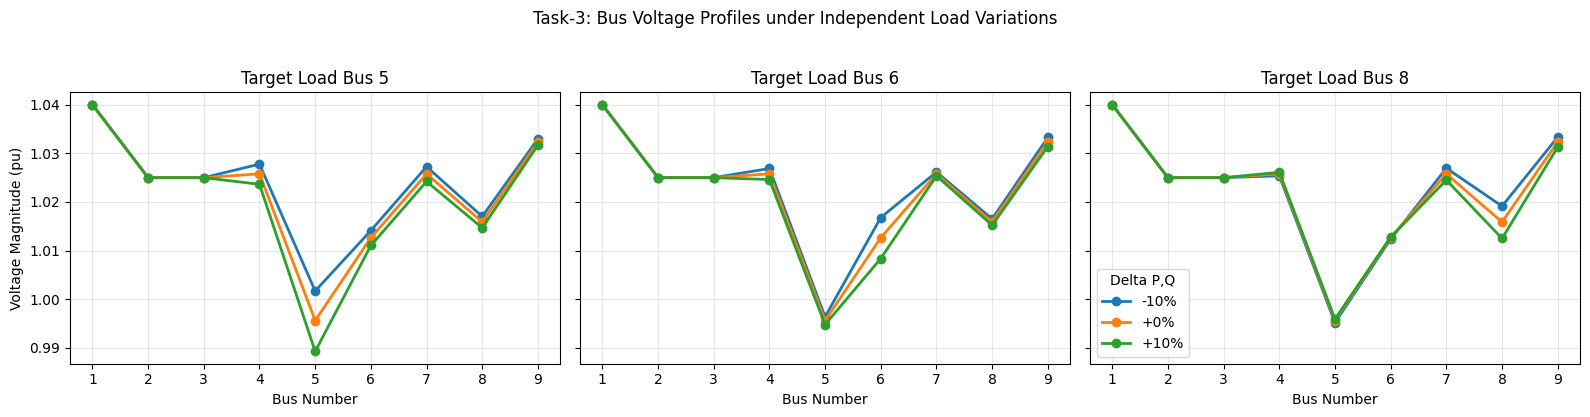

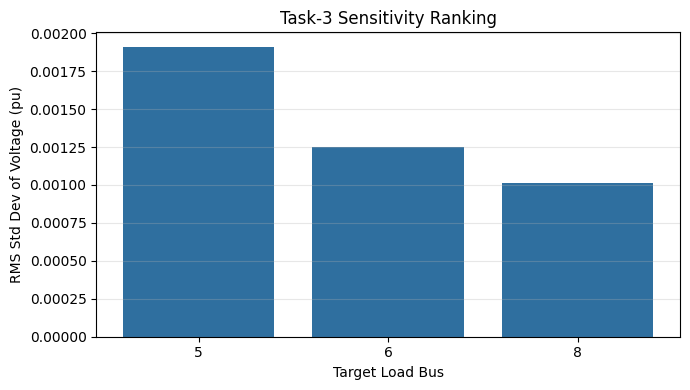

In [8]:
fig, axes = plt.subplots(1, len(load_bus_list), figsize=(16, 4), sharey=True)
if len(load_bus_list) == 1:
    axes = [axes]

for ax, target_bus in zip(axes, load_bus_list):
    subset = sensitivity_df[sensitivity_df["Target Load Bus"] == target_bus].sort_values("Variation (%)")

    for _, row in subset.iterrows():
        label = f"{int(row['Variation (%)']):+d}%"
        v_profile = [row[f"V_bus_{b}"] for b in bus_numbers]
        ax.plot(bus_numbers, v_profile, marker="o", linewidth=2, label=label)

    ax.set_title(f"Target Load Bus {target_bus}")
    ax.set_xlabel("Bus Number")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Voltage Magnitude (pu)")
axes[-1].legend(title="Delta P,Q")
plt.suptitle("Task-3: Bus Voltage Profiles under Independent Load Variations", y=1.03)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(ranking_df["Target Load Bus"].astype(str), ranking_df["RMS Std Dev"], color="#2f6f9f")
ax.set_xlabel("Target Load Bus")
ax.set_ylabel("RMS Std Dev of Voltage (pu)")
ax.set_title("Task-3 Sensitivity Ranking")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## Notes for Report Writing

- Use the **Task-1** tables for: convergence behavior, 2nd-iteration snapshot, final voltages, line flows, and losses.
- Use the **Task-3** tables/plots for: voltage variation behavior, variance-standard deviation evidence, and sensitivity ranking.
- The ranking identifies which single load-bus perturbation most strongly impacts overall bus voltages.
